# Object Detection

**Objective:** Develop a basic image classification web application that enables users to upload images and classify them into predefined categories such as animals, vehicles, or plants. This project will involve implementing essential computer vision techniques, building and deploying a machine learning model, and providing an interactive user interface for real-time image classification.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from keras import Sequential
from keras import layers, metrics, optimizers, datasets
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preparing the data

In [2]:
#Loading it directly from Keras datasets
cifar_df = keras.datasets.cifar10

In [3]:
#Now, we'll split it into training and testing
(train_images, train_labels), (test_images, test_labels) = cifar_df.load_data()

In [4]:
#Making a list of class labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_images, test_images = train_images / 255, test_images / 255

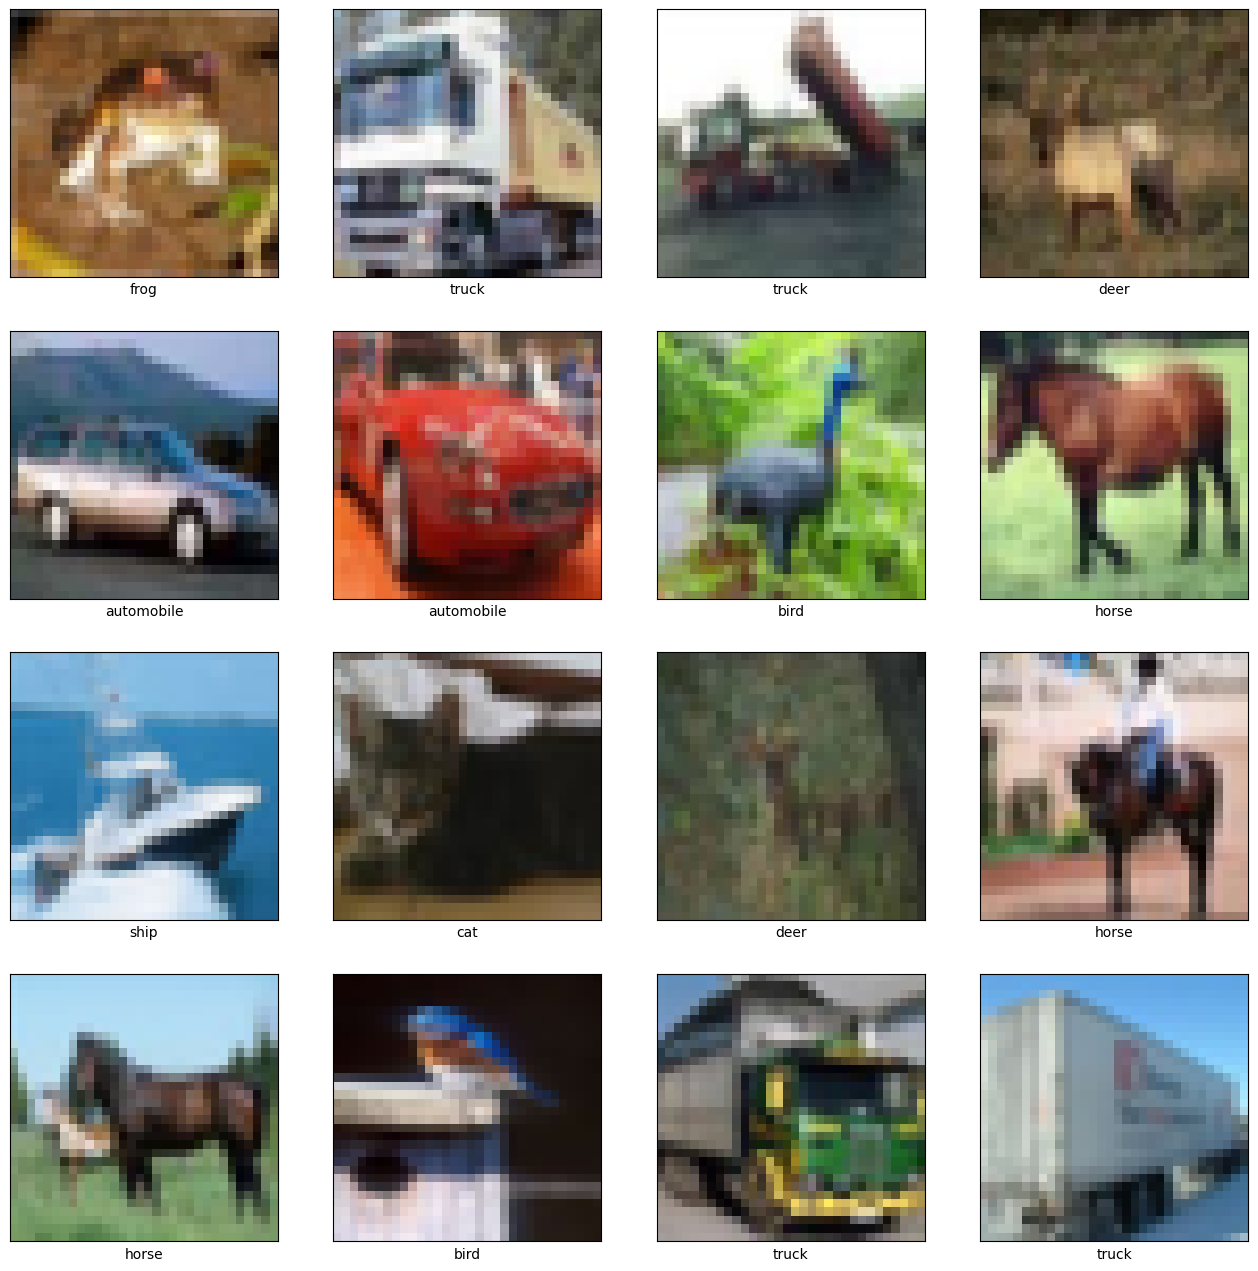

In [5]:
def plot_image():
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(train_images[i], cmap="binary")
        plt.xlabel(labels[train_labels[i][0]])
        plt.grid(False)
    plt.show()

plot_image()

In [6]:
print("Input_dim =",train_images.shape)
#Already flattened, best (need to reduce image to 1D array)

#50k images, width and height 32x32, 3 channels

Input_dim = (50000, 32, 32, 3)


Data Preparation by : Fahad Salman Amim

## Pre-trained model

In [7]:
# Loading the ResNet50 model with pre-trained ImageNet weights, excluding the top layers
resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [8]:
# Freezing the ResNet layers to prevent them from being trained
# resnet_base.trainable = False

In [9]:
 # Adding Custom Layers on Top of ResNet50
model = Sequential([
    resnet_base,
    layers.Flatten(),  # Flatten the output from ResNet
    layers.Dense(512, activation='relu'),  # Fully connected layer with 512 units
    layers.Dense(512, activation='relu'),  # Fully connected layer with 512 units
    layers.Dense(10, activation='softmax')  # Output layer with 10 units for the 10 classes
])

In [10]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [11]:
model.fit(train_images, train_labels, batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
625/625 [==============================] - 66s 86ms/step - loss: 1.2066 - accuracy: 0.5972 - val_loss: 2.8074 - val_accuracy: 0.1423
Epoch 2/40
625/625 [==============================] - 42s 68ms/step - loss: 0.9716 - accuracy: 0.6802 - val_loss: 1.1109 - val_accuracy: 0.6499
Epoch 3/40
625/625 [==============================] - 43s 68ms/step - loss: 0.7597 - accuracy: 0.7487 - val_loss: 1.8879 - val_accuracy: 0.4995
Epoch 4/40
625/625 [==============================] - 43s 68ms/step - loss: 0.6235 - accuracy: 0.7940 - val_loss: 1.0032 - val_accuracy: 0.6901
Epoch 5/40
625/625 [==============================] - 43s 68ms/step - loss: 0.5338 - accuracy: 0.8232 - val_loss: 0.9888 - val_accuracy: 0.7030
Epoch 6/40
625/625 [==============================] - 43s 69ms/step - loss: 0.4595 - accuracy: 0.8496 - val_loss: 0.7916 - val_accuracy: 0.7556
Epoch 7/40
625/625 [==============================] - 43s 69ms/step - loss: 0.3995 - accuracy: 0.8689 - val_loss: 1.0910 - val_accuracy:

In [12]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 7s 21ms/step - loss: 1.2377 - accuracy: 0.7802


[1.237701416015625, 0.7802000045776367]

1/1 [==============================] - 2s 2s/step


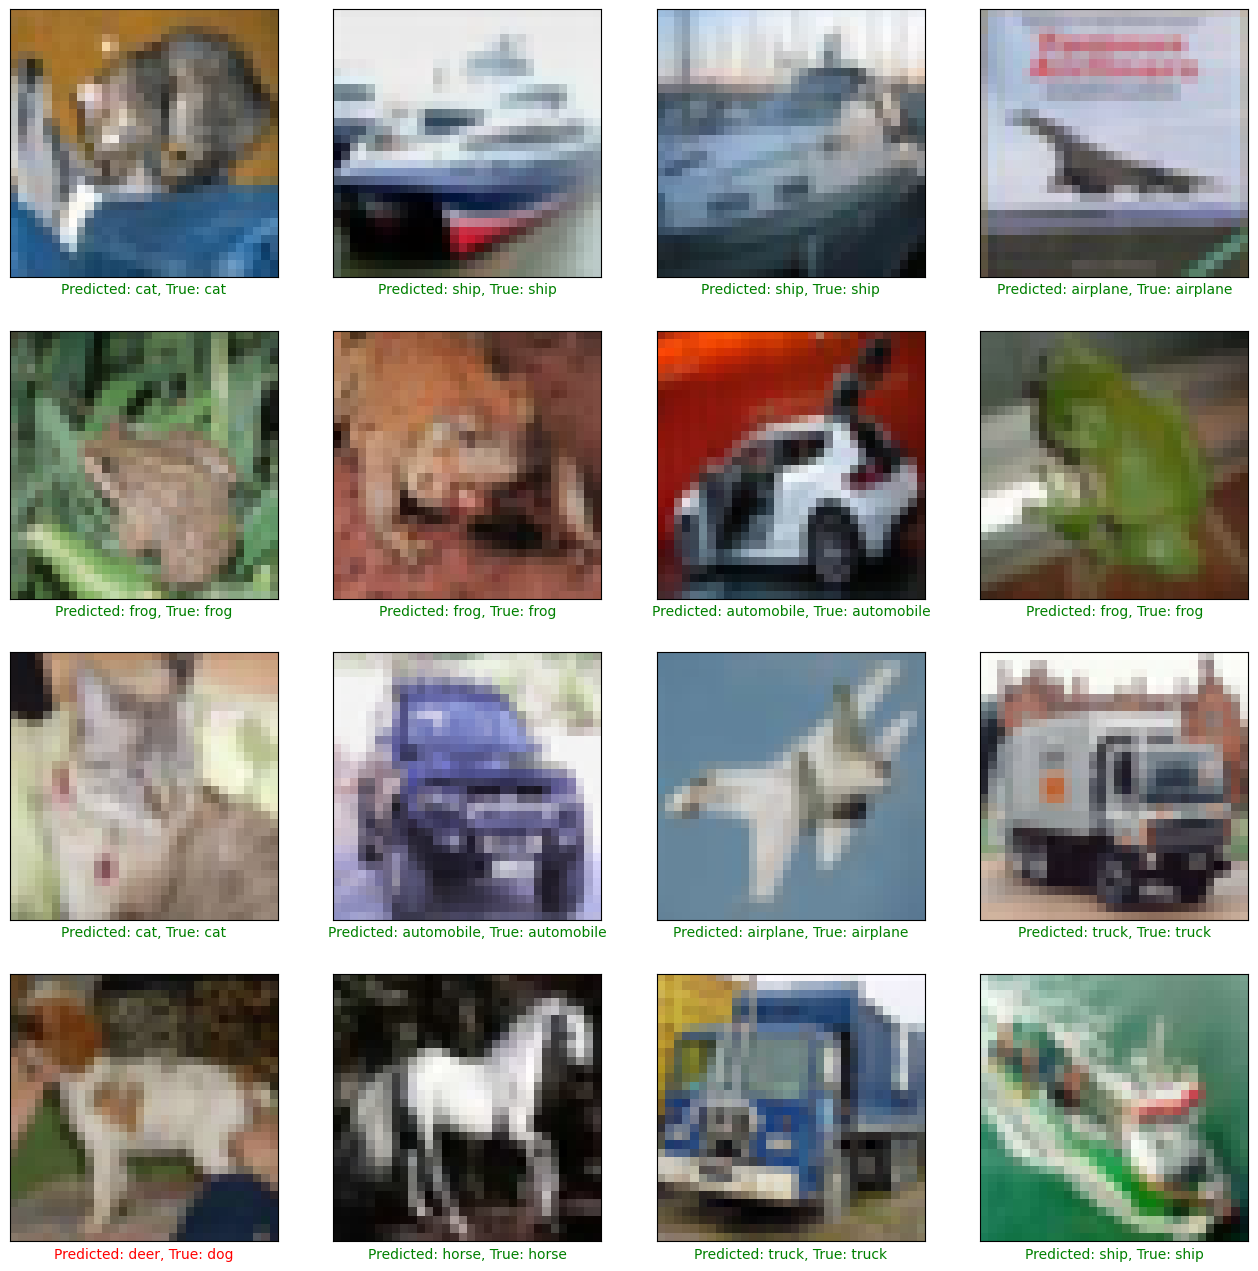

In [13]:
# Predict the first 16 images
predictions = model.predict(test_images[:16])

# Plot the first 16 images along with their predicted and true labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = np.squeeze(test_labels[i])  # Use squeeze function to get the true label
    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"Predicted: {class_names[predicted_label]}, True: {class_names[true_label]}", color=color)
plt.show()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,904,586
Trainable params: 24,851,466
Non-trainable params: 53,120
_________________________________________________________________


In [23]:
model.save("resnet_cifar10_model.h5")

### Applying ***Data Augmentation*** (adding an ImageDataGenerator to create more variations of the training data, which will helps the model learn better) and ***Fine Tuning*** (by freezing last 10 layers of the ResNet model and retraining them with a smaller learning rate) to improve accuracy.

In [23]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Fit the data generator on the training images
datagen.fit(train_images)

# Load the pre-trained ResNet50 model without the top layers
resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
resnet_base.trainable = False

In [ ]:
# Create a new model on top of the ResNet base
model2 = keras.models.Sequential([
    resnet_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model2.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using data augmentation
model2.fit(datagen.flow(train_images, train_labels, batch_size=64),
          epochs=50,
          validation_data=(test_images, test_labels))

# Unfreeze some of the last layers in the ResNet model for fine-tuning
for layer in resnet_base.layers[-10:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model2.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Continue training with fine-tuning
model2.fit(datagen.flow(train_images, train_labels, batch_size=64),
          epochs=50,
          validation_data=(test_images, test_labels))

In [ ]:
# Evaluate the model
test_loss, test_acc = model2.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.4f}")

In [ ]:
# Predict the first 16 images in the test set
predictions = model2.predict(test_images[:16])

In [ ]:
# Plot the first 16 images along with their predicted and true labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = np.squeeze(test_labels[i])  # Use squeeze function to get the true label
    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"Predicted: {class_names[predicted_label]}, True: {class_names[true_label]}", color=color)
plt.show()

In [ ]:
# Save the model
# model.save("resnet_cifar10_model.h5")

### ResNet done by: Malaika Ahmed (15/08/2024)
***
***
***

## Custom Model

As the pre-trained ResNet appears to be overfitting, we will also create our own CNN model just in case

In [40]:
model3 = Sequential()
#Utilizing Batch Normalization, which will normalize the input layer by adjusting and scaling the activations

model3.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same',input_shape = (32, 32, 3)))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same',input_shape = (32, 32, 3)))
model3.add(layers.BatchNormalization())

model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Dropout(0.25))

model3.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same',input_shape = (32, 32, 3)))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same',input_shape = (32, 32, 3)))
model3.add(layers.BatchNormalization())

model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Dropout(0.35))

model3.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same',input_shape = (32, 32, 3)))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same',input_shape = (32, 32, 3)))
model3.add(layers.BatchNormalization())

model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Dropout(0.45))

model3.add(layers.Flatten())
model3.add(layers.Dense(units = 512, activation = 'relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(units = 10, activation = 'softmax'))


In [44]:
from keras.utils import to_categorical

# Load the CIFAR-10 dataset
cifar_df = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar_df.load_data()

# Normalize the data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# One-hot encode the labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model3.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=50, batch_size=64)

Epoch 1/50
782/782 [==============================] - 18s 20ms/step - loss: 1.6623 - accuracy: 0.4439 - val_loss: 1.2232 - val_accuracy: 0.5702
Epoch 2/50
782/782 [==============================] - 14s 18ms/step - loss: 1.0839 - accuracy: 0.6152 - val_loss: 1.0751 - val_accuracy: 0.6222
Epoch 3/50
782/782 [==============================] - 13s 16ms/step - loss: 0.9102 - accuracy: 0.6781 - val_loss: 0.7811 - val_accuracy: 0.7255
Epoch 4/50
782/782 [==============================] - 13s 17ms/step - loss: 0.8079 - accuracy: 0.7174 - val_loss: 0.8230 - val_accuracy: 0.7070
Epoch 5/50
782/782 [==============================] - 14s 18ms/step - loss: 0.7345 - accuracy: 0.7425 - val_loss: 0.7588 - val_accuracy: 0.7305
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 0.6813 - accuracy: 0.7626 - val_loss: 0.6382 - val_accuracy: 0.7813
Epoch 7/50
782/782 [==============================] - 13s 16ms/step - loss: 0.6329 - accuracy: 0.7769 - val_loss: 0.6844 - val_accuracy:

<Axes: >

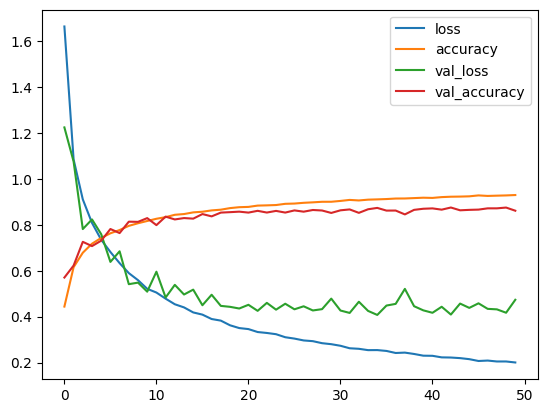

In [45]:
pd.DataFrame(history.history).plot()

In [46]:
model3.save("cifar10_model.h5")

Custom Model trained by : Fahad Salman Amim

***
*** 
*** 

## Getting the model working on our own images

1/1 [==============================] - 0s 172ms/step
Predicted class: frog with confidence 99.97


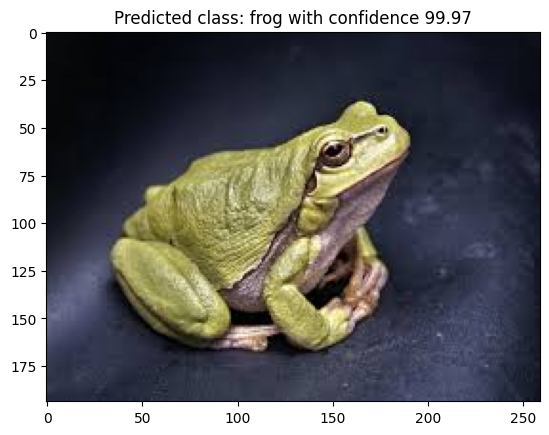

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

custom_model = load_model("cifar10_model.h5")

# Step 1: Load and preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(32, 32))  # Resize to 32x32
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array.astype('float32') / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension, as model expects (batch_dim, 32, 32, 3) instead of (32, 32, 3)
    return img_array

# Provide the path to your image
img_path = 'frog_test.jpg'
img_array = preprocess_image(img_path)

# Step 2: Make predictions
predictions = custom_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_confidence = (predictions[0][predicted_class_index]) * 100

# CIFAR-10 class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

# Print the predicted class and confidence
predicted_class = class_labels[predicted_class_index]
print(f'Predicted class: {predicted_class} with confidence {predicted_confidence:.2f}')

# Optionally, display the image
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted class: {predicted_class} with confidence {predicted_confidence:.2f}')
plt.show()